# Проект: телекоммуникации

<a id='task'></a>
## Постановка задачи

**Тема проекта:** разработка модели машинного обучения, предсказывающей разорвёт ли абонент договор.

### Описание услуг
Оператор предоставляет два основных типа услуг: 
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (`DSL`, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (`Fiber optic`).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (`DeviceProtection`) и блокировка небезопасных сайтов (`OnlineSecurity`);
- Выделенная линия технической поддержки (`TechSupport`);
- Облачное хранилище файлов для резервного копирования данных (`OnlineBackup`);
- Стриминговое телевидение (`StreamingTV`) и каталог фильмов (`StreamingMovies`).

Клиенты могут платить за услуги каждый месяц или заключить договор на 1–2 года. Возможно оплатить счёт разными способами, а также получить электронный чек.

### Назначение

**Цели проекта:** обучить модель машинного обучения для прогноза оттока клиентов.

**Метрика:** ROC-AUC >= 0.85

### Структура проекта
1. [Постановка задачи][1]
    1. Назначение
    2. Структура проекта
    3. Описание данных
2. [Загрузка и подготовка данных][2]
3. [Предобработка данных][3]
4. [Исследовательский анализ данных][4]
    1. [Численные признаки][4.1]
    2. [Категориальные признаки][4.2]
    3. [Корреляция][4.3]
    4. [Общий вывод по исследовательскому анализу данных][4.4]
5. [Обучение моделей машинного обучения][5]
    1. [Предобработка данных][5.1]
    2. [Константная модель][5.2]
    3. [Логистическая регрессия][5.3]
    4. [Дерево решений][5.4]
    5. [Случайный лес][5.5]
    6. [Модель LightGBM][5.6]
    7. [Модель Catboost][5.7]
6. [Выбор лучшей модели][6]
7. [Отчет][7]

[1]:#task
[2]:#general
[3]:#preprocess
[4]:#research
[4.1]:#num
[4.2]:#cat
[4.3]:#corr
[4.4]:#resan
[5]:#mod
[5.1]:#bef
[5.2]:#const
[5.3]:#log
[5.4]:#tree
[5.5]:#forest
[5.6]:#lgbm
[5.7]:#catboost
[6]:#best
[7]:#fin

### Описание данных

Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

-------------------------------------------------------
**Файл `contract_new.csv`**

- `customerID` — идентификатор абонента;
- `BeginDate` — дата начала действия договора;
- `EndDate` — дата окончания действия договора;
- `Type` — тип оплаты: раз в год-два или ежемесячно;
- `PaperlessBilling` — электронный расчётный лист;
- `PaymentMethod` — тип платежа;
- `MonthlyCharges` — расходы за месяц;
- `TotalCharges` — общие расходы абонента.

-------------------------------------------------------
**Файл `personal_new.csv`**

- `customerID` — идентификатор пользователя;
- `gender` — пол;
- `SeniorCitizen` — является ли абонент пенсионером;
- `Partner` — есть ли у абонента супруг или супруга;
- `Dependents` — есть ли у абонента дети.

-------------------------------------------------------
**Файл internet_new.csv**

- `customerID` — идентификатор пользователя;
- `InternetService` — тип подключения;
- `OnlineSecurity` — блокировка опасных сайтов;
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных;
- `DeviceProtection` — антивирус;
- `TechSupport` — выделенная линия технической поддержки;
- `StreamingTV` — стриминговое телевидение;
- `StreamingMovies` — каталог фильмов.

-------------------------------------------------------
**Файл `phone_new.csv`**

- `customerID` — идентификатор пользователя;
- `MultipleLines` — подключение телефона к нескольким линиям одновременно.

-------------------------------------------------------
Во всех файлах столбец `customerID` содержит код клиента. Информация о договорах актуальна на **1 февраля 2020 года**.

Данные также находятся в тренажёре, в папке `/datasets/`.

<a id='general'></a>
## Загрузка и подготовка данных

Подготовка к работе с данными: загружаем библиотеки.

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
import re
import sklearn


try:
    import phik
except:
    !pip install phik
    import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    MinMaxScaler
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix
)

# загружаем нужные модели
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
try:
    import lightgbm
except:
    !pip install lightgbm
    import lightgbm    
    
from lightgbm import LGBMClassifier

try:
    import catboost
except:
    !pip install catboost
    import catboost   
from catboost import CatBoostClassifier

# библиотеки для графиков
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install sklearn==1.5.0 --quiet

ERROR: Ignored the following yanked versions: 0.0.post2
ERROR: Could not find a version that satisfies the requirement sklearn==1.5.0 (from versions: 0.0, 0.0.post1, 0.0.post4, 0.0.post5, 0.0.post7, 0.0.post9, 0.0.post10, 0.0.post11, 0.0.post12)
ERROR: No matching distribution found for sklearn==1.5.0


In [3]:
RANDOM_STATE = 50824
TEST_SIZE = 0.25

In [4]:
# подготовка для графиков
palette = ["#F72585", "#4361EE",
           "#b5179e", "#4CC9F0", 
           "#7209B7", "#3A0CA3"]
sns.set(rc={'figure.figsize':(7, 6)},
        palette=palette, 
        font_scale=0.95)
sns.set_style(rc = {'axes.facecolor': '#e9e9f0'})

In [5]:
pd.set_option('max_columns', None)

# расширение границ для работы с тетрадкой
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Считываем датафреймы.

In [6]:
# функция считывания датафрейма
def read_dfs(path, name, sep, parse_dates=None):
    for i in path:
        if os.path.exists(i+name):
            return pd.read_csv(
                i+name, 
                sep=sep[0], 
                decimal=sep[1],
                parse_dates=parse_dates,
                dayfirst=True
            )
    return print('File not found')

# функция вывода информации о датафреймах
def df_info(df):
    print(df.info())
    return df.head(10)

In [7]:
# считываем датафреймы
# записываем возможные пути
paths = ['/datasets/', 
         'C:\\Users\\Admin\\YandexDisk\\']
# разделение данных
sep=[',', '.']

In [8]:
df_name = 'contract_new.csv'
contract = read_dfs(paths, df_name, sep, ['BeginDate', 'EndDate'])

df_info(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB
None


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


В датафрейме `contract` 7043 записи, пропусков нет. Тип данных столбца `TotalCharges` далее необходимо поменять на `float`, а `EndDate` на `datetime`, `No` в данном столбце означает, что пользователь продолжает пользоваться услугами, то есть столбец является **целевым признаком**.

In [9]:
df_name = 'personal_new.csv'
personal = read_dfs(paths, df_name, sep)

df_info(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


В датафрейме `personal` 7043 записи, пропусков нет. Типы данных правильные.

In [10]:
df_name = 'internet_new.csv'
internet = read_dfs(paths, df_name, sep)

df_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


В датафрейме `internet` 5517 записей, пропусков нет. Типы данных правильные.

In [11]:
df_name = 'phone_new.csv'
phone = read_dfs(paths, df_name, sep)

df_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


В датафрейме `phone` 6361 запись, пропусков нет. Типы данных правильные.

**Вывод:** 
- `contract` содержит 7043 записи, пропусков нет. 
    - Тип данных столбца `TotalCharges` далее необходимо поменять на `float`.
    - `EndDate` на `datetime`.
    - На основе `EndDate` можно создать столбец с **целевым признаком** (`No` - означает, что клиент все еще пользуется услугами). 
- `personal` содержит 7043 записи, пропусков нет. Типы данных правильные.
- `internet` содержит 5517 записей, пропусков нет. Типы данных правильные.
- `phone` содержит 6361 запись, пропусков нет. Типы данных правильные.

<a id='preprocess'></a>
## Предобработка данных

Переименуем названия столбцов всех датафреймов, приведя их к змеиному регистру.

In [12]:
dfs = [contract, personal, internet, phone]

for df in dfs:
    df.columns = [
        re.sub(r"(?<!^)(?<![A-Z])(?=[A-Z])", "_", column_name).lower()
        for column_name in df.columns
    ]
    print(df.columns.to_list())

['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing', 'payment_method', 'monthly_charges', 'total_charges']
['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents']
['customer_id', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
['customer_id', 'multiple_lines']


В датафрейме `contract` создадим столбец `no_contract` с целевым признаком (по признаку `end_date`):
- 1 - контракт разорван;
- 0 - контракт НЕ разорван.

Вместо `No` запишем последнюю актуальную дату - `2020-02-01`. И поменяем тип данных этого столбца на `datetime`.

In [13]:
contract['no_contract'] = (contract['end_date'] != 'No').astype(int)
contract.loc[(contract['end_date'] == 'No'), 'end_date'] = '2020-02-01'
contract['end_date'] = pd.to_datetime(contract['end_date'], format= "%Y/%m/%d")

df_info(contract)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   object        
 8   no_contract        7043 non-null   int32         
dtypes: datetime64[ns](2), float64(1), int32(1), object(5)
memory usage: 467.8+ KB
None


,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,no_contract
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1


Проверим строки в `total_charges` с отсутствующими данными (`' '`).

In [14]:
contract[contract['total_charges']== ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,no_contract
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,,0


Все эти контракты - совсем новые, оплата либо еще не поступила, либо не была занесена в базу. Пропуски в общих расходах заменим расходами за месяц.

In [15]:
contract.loc[(contract['total_charges']== ' '), \
             'total_charges'] = contract['monthly_charges']

# проверка правильного заполнения
print(contract.loc[(contract['customer_id']== '4472-LVYGI'), \
                   'total_charges'])
print(contract.loc[(contract['customer_id']== '1371-DWPAZ'), \
                   'total_charges'])
print(contract.loc[(contract['customer_id']== '4075-WKNIU'), \
                   'total_charges'])

488    52.55
Name: total_charges, dtype: object
1340    56.05
Name: total_charges, dtype: object
6670    73.35
Name: total_charges, dtype: object


Теперь меняем тип данных столбца `total_charges` на `float`.

In [16]:
contract['total_charges'] = contract['total_charges'].astype(float)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   no_contract        7043 non-null   int32         
dtypes: datetime64[ns](2), float64(2), int32(1), object(4)
memory usage: 467.8+ KB


Объединим таблицы в один датафрейм.

In [17]:
# проверяем кол-во признаков и записей
contract.shape, personal.shape, \
internet.shape, phone.shape

((7043, 9), (7043, 5), (5517, 8), (6361, 2))

In [18]:
full_df = contract.merge(personal, how='outer')
full_df = full_df.merge(internet, how='outer')
full_df = full_df.merge(phone, how='outer')
print(full_df.shape)

(7043, 21)


Добавим дополнительный признак - длительность контракта.

In [19]:
full_df['contract_duration'] = (full_df['end_date']\
                                - full_df['begin_date'])\
.dt.days
full_df.isna().sum()

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
no_contract             0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
contract_duration       0
dtype: int64

Датафреймы объединили успешно, но появились пропуски. Заполним их значением `No`, т.к. в данных признаках пропуск означает отсутствие услуги.

In [20]:
full_df = full_df.fillna('No')
full_df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
no_contract          0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
contract_duration    0
dtype: int64

**Вывод:** в результате предобработки данных 
- Названия столбцов приведены к змеиному регистру; 
- В датафрейме `contract` создан столбец `no_contract` с целевым признаком (данные взяты из `end_date`, где значение `No` - не разорванный контракт):
    - 1 - контракт разорван;
    - 0 - контракт НЕ разорван.
- Вместо `No` в столбце `end_date` записана последняя актуальная дата - `2020-02-01`;
- Пропуски данных (`' '`) в столбце `total_charges` заменены на расходы за месяц, т.к. все контракты с пропусками - новые и, видимо, оплата еще не проводилась, либо данные пока не были занесены в базу данных;
- изменены типы данных тип данных:
    - в `end_date` на `datetime`;
    - в `total_charges` на `float`.
- Все таблицы упешно объединены в один датафрейм (`full_df`) по `customer_id`: пропуски заполнены значением `No` (т.к. пропуски означают отсутствие услуги).

<a id='research'></a>
## Исследовательский анализ данных

In [21]:
# функция гистограммы для сравнения по целевому признаку
def hist_comparsion(df_no, df_yes, feature, binss):
    ax = df_yes.plot(
        kind='hist',
        y=feature,
        bins=binss,
        alpha=1,
        label='Контракт есть'
    )
    df_no.plot(
        kind='hist',
        y=feature,
        bins=binss,
        alpha=.6,
        label='Контракт разорван',
        ax=ax,
        grid=True
    )
    plt.title(feature)
    plt.ylabel('Кол-во абонентов')
    plt.xlabel(feature)
    plt.show()
    
    
# функция построения двух боксплотов для сравнения
# по целевому признаку
def box_comparsion(df_no, df_yes, feature):
    plt.figure(figsize=(10, 5))

    # 1 строка, 2 столбца. Текущая ячейка 1
    plt.subplot(1, 2, 1)
    sns.boxplot(x=df_no[feature].values)
    plt.title('Контракт разорван')
    plt.xlabel(feature)
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_yes[feature].values)
    plt.title('Контракт есть')
    plt.xlabel(feature)

    plt.show()

In [22]:
# функция построения графика ДОЛЕЙ для категориальных признаков
def catplot_cmprsn(df, col):
    sns.histplot(
        df,
        y=col,
        hue='no_contract',
        stat='probability',
        multiple='dodge')
    plt.title(col)
    plt.ylabel(col)
    plt.xlabel('Частота')
          
    plt.show()

In [23]:
# разделим данные по целевому признаку для анализа
contract_on = full_df[full_df['no_contract'] == 0]
contract_on = contract_on.drop(
    ['customer_id', 'no_contract'], axis=1)
contract_off = full_df[full_df['no_contract'] == 1]
contract_off = contract_off.drop(
    ['customer_id', 'no_contract'], axis=1)

<a id='num'></a>
### Численные признаки

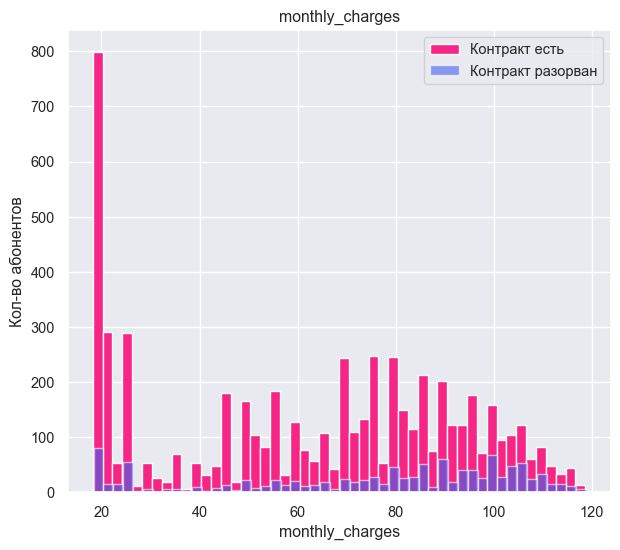

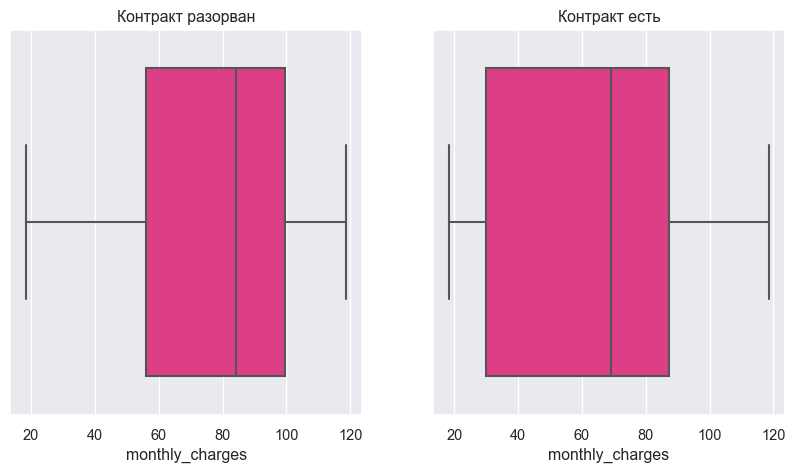

In [24]:
hist_comparsion(contract_off, contract_on, 
                'monthly_charges', 50)
box_comparsion(contract_off, contract_on, 
               'monthly_charges')

In [25]:
print(round(contract_off['monthly_charges'].describe(), 2))
print()
print(round(contract_on['monthly_charges'].describe(), 2))

count    1101.00
mean       75.55
std        29.12
min        18.40
25%        56.15
50%        84.20
75%        99.50
max       118.75
Name: monthly_charges, dtype: float64

count    5942.00
mean       62.76
std        29.84
min        18.25
25%        30.06
50%        69.20
75%        87.24
max       118.60
Name: monthly_charges, dtype: float64


**Данные чистые, аномалий и выбросов нет.**

Пользователей с продолжающимся контрактом значительно больше.

Медианное и среднее значения **ежемесячных расходов больше у пользователей, разорвавших контракт** (`84.20` против `69.20` по медиане, `75.55` против `62.76` по среднему). Также минимальное и максимальное значения у ушедших клиентов больше, хоть и не значительно (разница в десятых-сотых).

Самый высокий пик - на минимальных значениях. Но у ушедших можно наблюдать второй пик у `100` (у остающихся в районе `70-80`), то есть разрывают контракты чаще либо на минимальной стоимости, либо при больших ежемесячных расходах. 

На графике видны множественные пики, что, скорее всего, связано с количеством подключенных услуг.

Посмотрим на общие расходы абонентов.

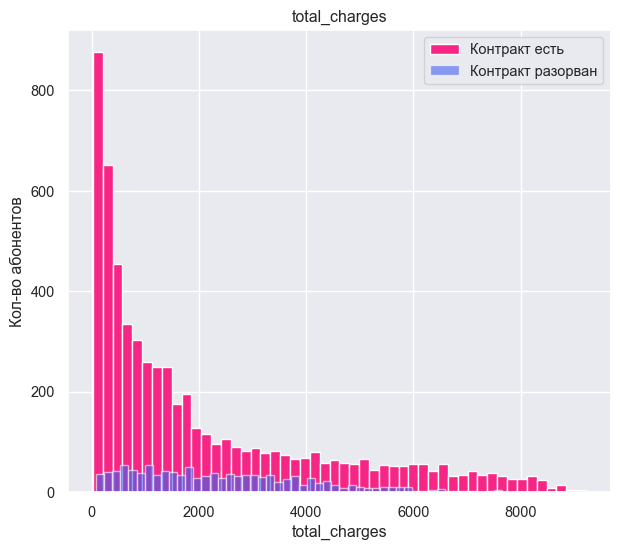

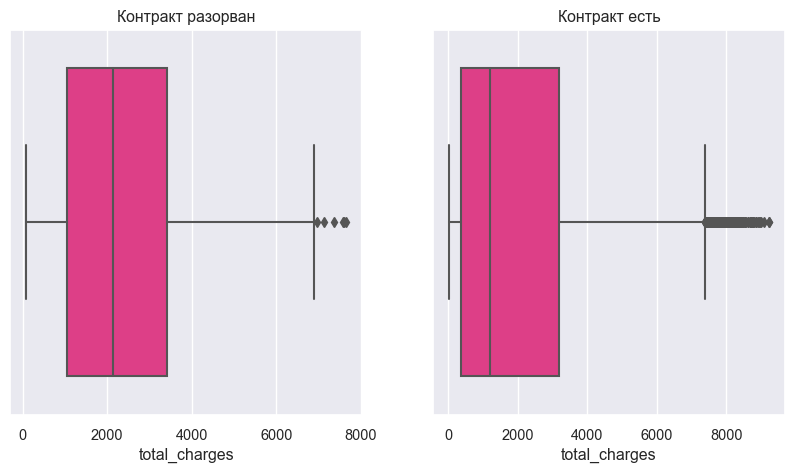

In [26]:
hist_comparsion(contract_off, contract_on, 
                'total_charges', 50)
box_comparsion(contract_off, contract_on, 
               'total_charges')

In [27]:
print(round(contract_off['total_charges'].describe(), 2))
print()
print(round(contract_on['total_charges'].describe(), 2))

count    1101.00
mean     2371.38
std      1581.86
min        77.84
25%      1048.05
50%      2139.03
75%      3404.91
max      7649.76
Name: total_charges, dtype: float64

count    5942.00
mean     2067.94
std      2193.83
min        19.05
25%       374.35
50%      1192.80
75%      3173.84
max      9221.38
Name: total_charges, dtype: float64


**Аномалий в данных нет, выбросы на распределении - возможные знаения, их исправлять не надо.**

Медиана и среднее **общих расходов абонентов, разорвавших контракт**, больше чем у остающихся с компанией (`2139.03` против `1192.80` по медиане, `2371.38` против `2067.94` по среднему), так же как и минимальное (`77.84` против `19.05`), при этом максимальное значение выше у оставшихся абонентов (`7649.76` против `9221.38`).

Значения убывают, то есть бОльшая часть клиентов не пользуется большинтсвом предоставляемых услуг.

Посмотрим на длительность контрактов в днях.

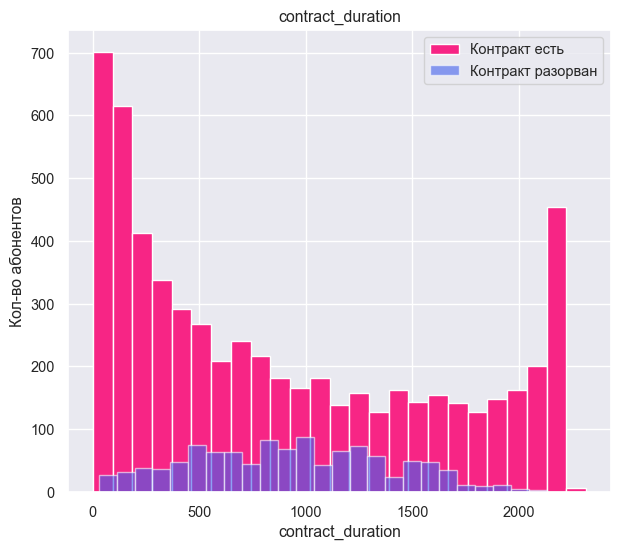

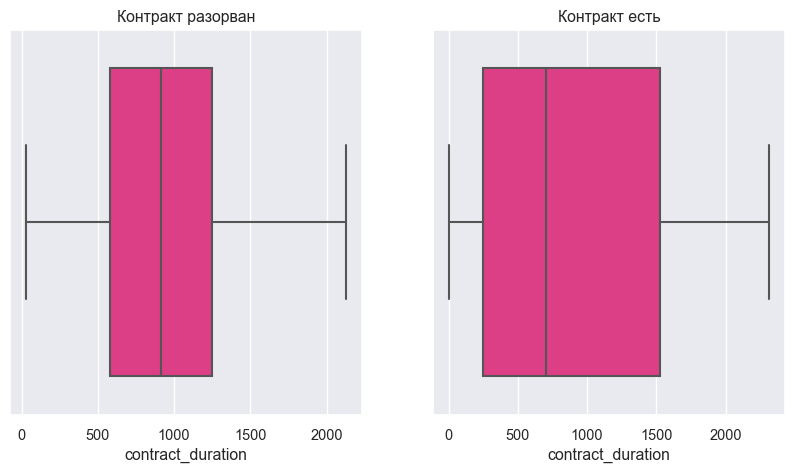

In [28]:
hist_comparsion(contract_off, contract_on, 
                'contract_duration', 25)
box_comparsion(contract_off, contract_on, 
               'contract_duration')

In [29]:
print(round(contract_off['contract_duration'].describe(), 2))
print()
print(round(contract_on['contract_duration'].describe(), 2))

count    1101.00
mean      924.86
std       458.77
min        28.00
25%       577.00
50%       915.00
75%      1249.00
max      2129.00
Name: contract_duration, dtype: float64

count    5942.00
mean      893.68
std       716.96
min         0.00
25%       245.00
50%       702.00
75%      1523.00
max      2314.00
Name: contract_duration, dtype: float64


**Данные чистые, аномалий и выбросов нет.**

Пик на максимальной длительности и минимальное количество дней, равное `0`, у лояльных клиентов связан с тем, что выше датой окончания контракта была выбрана актуальная дата (вместо значения `No`), это значит, что некоторые абоненты только присоединились или продолжают сотруднечество с компанией.

По медиане и среднему значениям разорвавшие контракт сотрудничали дольше (`915` против `702` по медиане, `924.86` против `893.68` по среднему). Но максимальное значение у остающихся - `2314` против `2129`.

**Вывод по численным признакам:** данные чистые, аномалий и выбросов нет. Пользователей с продолжающимся контрактом значительно больше.

- Медианное и среднее значения **ежемесячных расходов больше у пользователей, разорвавших контракт** (`84.20` против `69.20` по медиане, `75.55` против `62.76` по среднему). 
    - Минимальное и максимальное значения у ушедших абонентов больше, хоть и не значительно (разница в десятых-сотых).
    - Самый высокий пик - на минимальных значениях. Но уушедших клиентов в можно наблюдать второй пик у `100` (у остающихся в районе `70-80`), то есть разрывают контракты чаще либо на минимальной стоимости, либо при больших ежемесячных расходах. 
    - На графике видны множественные пики, что, скорее всего, связано с количеством подключенных услуг.


- Медиана и среднее **общих расходов абонентов, разорвавших контракт**, больше чем у лояльных клиентов (`2139.03` против `1192.80` по медиане, `2371.38` против `2067.94` по среднему).
    - Минимальное значение также больше у ушедших (`77.84` против `19.05`), при этом максимальное значение выше у остающихся (`7649.76` против `9221.38`).
    - Значения убывают, то есть бОльшая часть клиентов не пользуется большинтсвом предоставляемых услуг.

- По медиане и среднему значениям разорвавшие контракт **сотрудничали дольше** (`915` против `702` по медиане, `924.86` против `893.68` по среднему).
    - Максимальное значение у остающихся - `2314` против `2129`.
    - На графике видно два пика среди остающихся - у новых абонентов и у лояльных долгих клиентов.
    - У разовравших контракт пик примерно соответствует медиане/среднему - `900-1000` дней.

<a id='cat'></a>
### Категориальные признаки

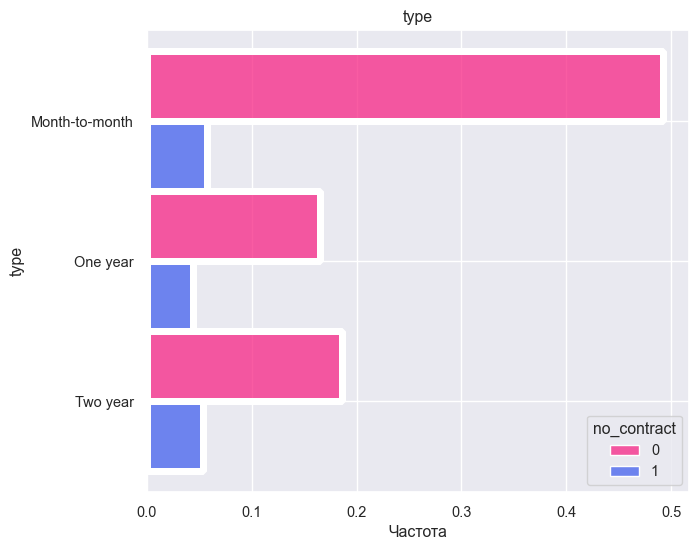

In [30]:
catplot_cmprsn(full_df, 'type')

Самый популярный способ оплаты - ежемесячный. Но среди ушедших клиентов разница в долях по типам оплаты не большая.

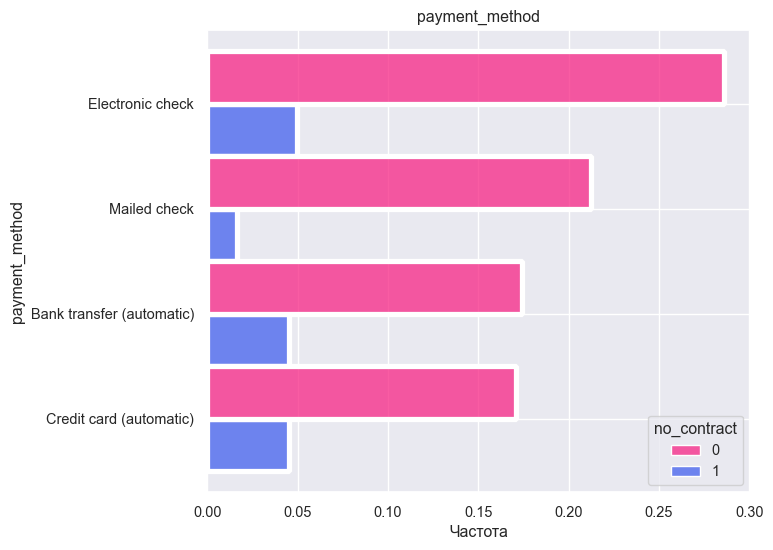

In [31]:
catplot_cmprsn(full_df, 'payment_method')

По типам платежа значительно лидирует электронный чек.

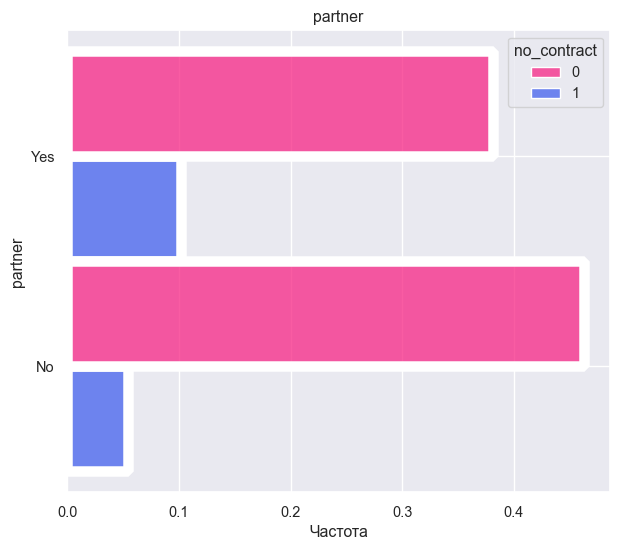

In [32]:
catplot_cmprsn(full_df, 'partner')

У большинства ушедших абонентов есть партнер, а у большинства оставшихся нет.

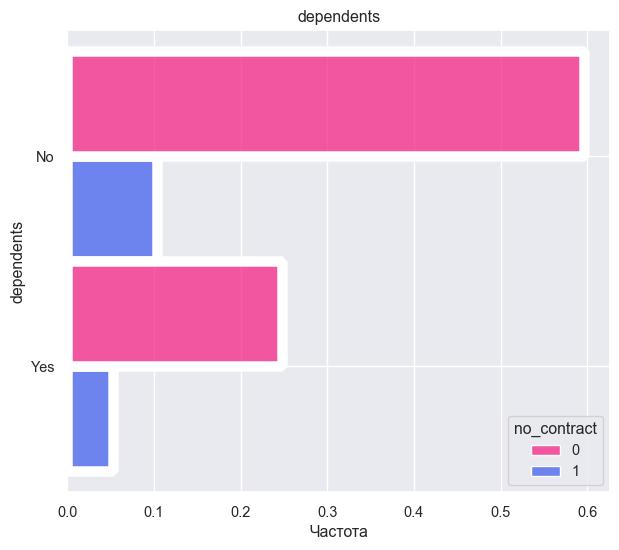

In [33]:
catplot_cmprsn(full_df, 'dependents')

У большинства абонентов нет детей.

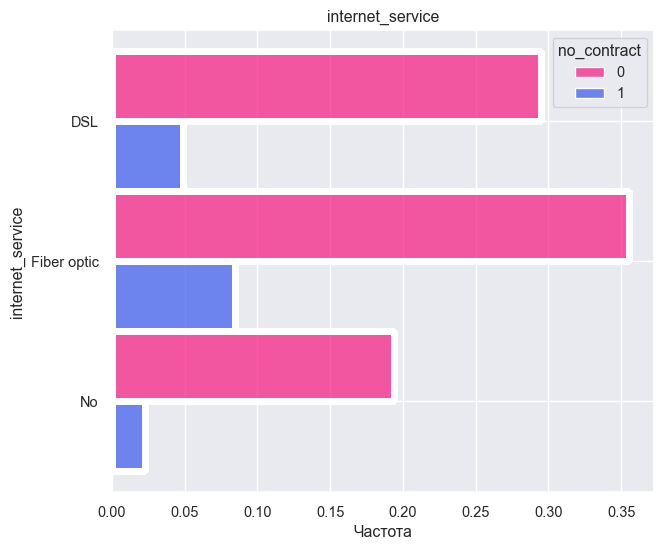

In [34]:
catplot_cmprsn(full_df, 'internet_service')

Самый частый способ подключения среди клиентов - оптоволоконный кабель.

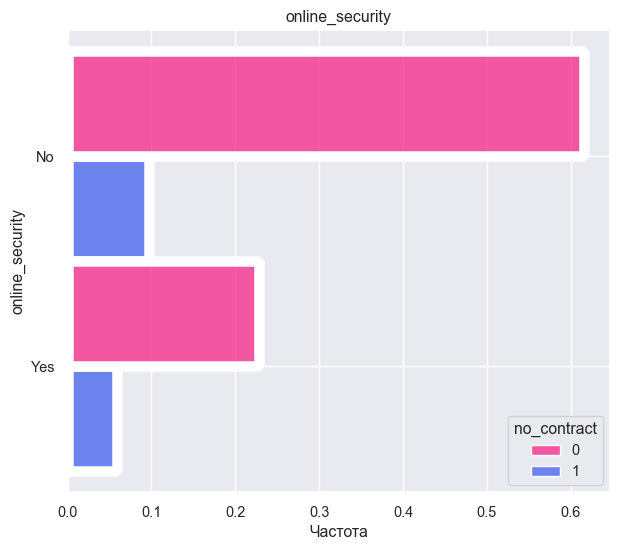

In [35]:
catplot_cmprsn(full_df, 'online_security')

Абоненты редко пользуются услугой блокировки опасных сайтов.

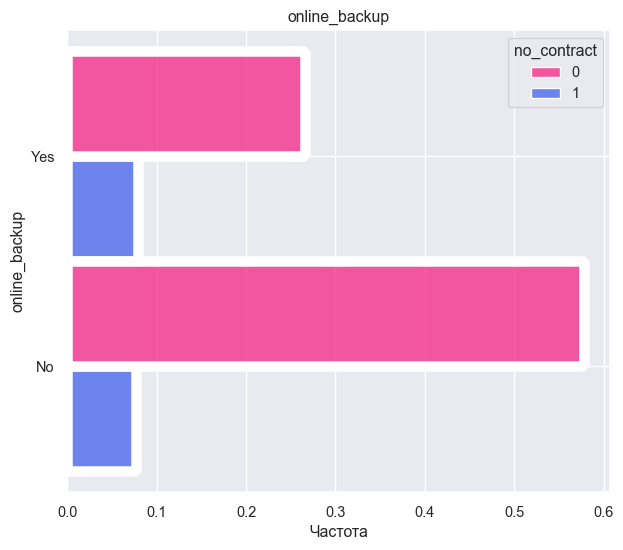

In [36]:
catplot_cmprsn(full_df, 'online_backup')

Среди разорвавших контракт доля клиентов, купивших услугу облачного хранилища файлов для резервного копирования данных, немного превышает долю ушедших клиентов без данной услуги. Среди лояльных клиентов эта услуга встречается не менее часто.

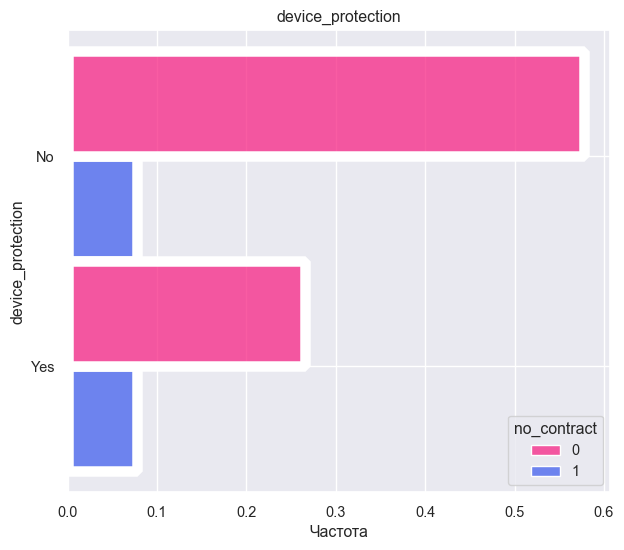

In [37]:
catplot_cmprsn(full_df, 'device_protection')

Лояльные клиенты чаще не пользуются антивирусов, но среди ушедших доли пользующихся и нет практически равны.

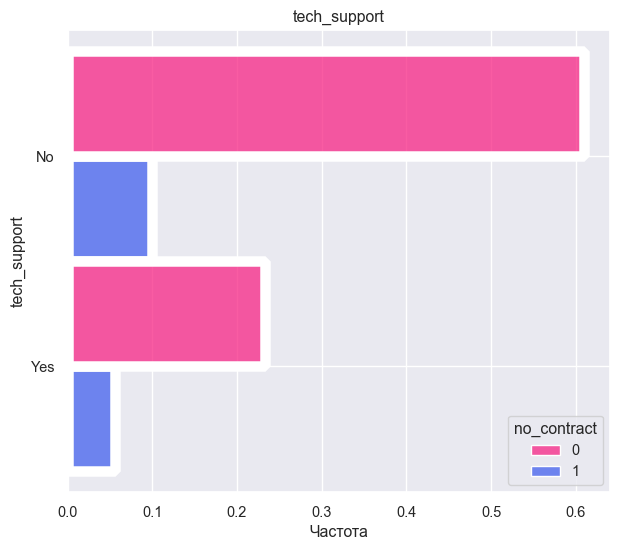

In [38]:
catplot_cmprsn(full_df, 'tech_support')

Улуга выделенной линии технической поддержки не пользуется популярностью среди клиентов.

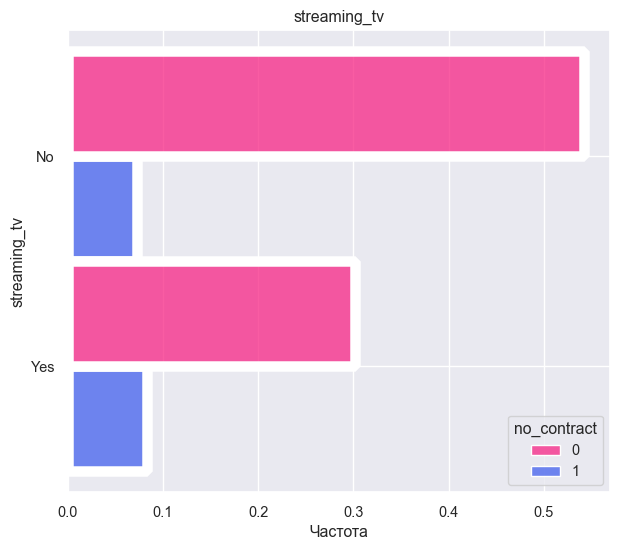

In [39]:
catplot_cmprsn(full_df, 'streaming_tv')

Стриминговое телевидение не очень интересует лояльных клиентов. Среди разорвавших контракт абонентов доля имевших эту услугу слегка больше, чем не имевших.

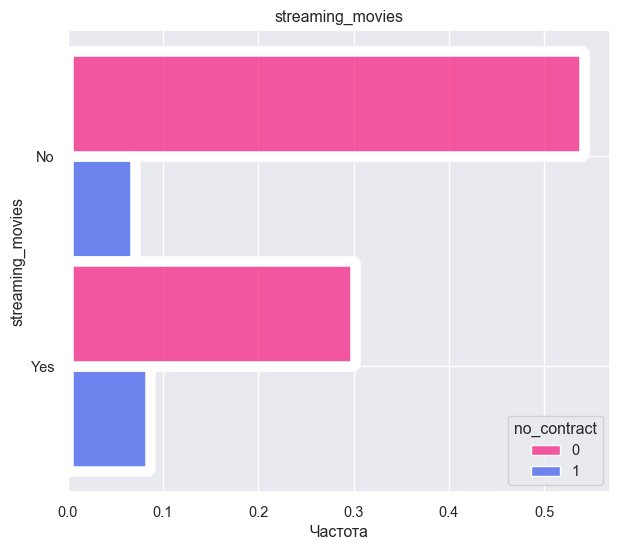

In [40]:
catplot_cmprsn(full_df, 'streaming_movies')

С каталогом фильмов ситуация, как со стриминговым телевидением: лояльных абонентов не особо интересует, а вот среди разорвавших контракт доля имевших данную услугу выше, чем не имевших.

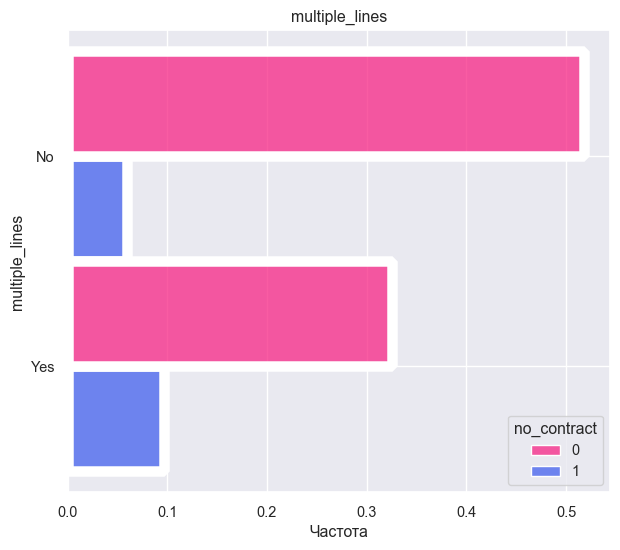

In [41]:
catplot_cmprsn(full_df, 'multiple_lines')

И опять же подключение телефона к нескольким линиям одновременно обычно не интересует остающихся клиентов, но среди ушедших доля имевших услугу больше, чем не имевших.

**Вывод по категориальным признакам:**
- Самый популярный **способ оплаты - ежемесячный**. 
    - Но среди ушедших клиентов разница в долях по типам оплаты не особо большая.
- **По типам платежа значительно лидирует электронный чек.**
- **У большинства ушедших абонентов есть партнер**, а у большинства оставшихся нет.
- У большинства абонентов **нет детей**.
- Самый частый **способ подключения** среди клиентов - **оптоволоконный кабель**.
- Абоненты редко пользуются услугой блокировки опасных сайтов.
- **Среди разорвавших контракт доля клиентов, купивших услугу облачного хранилища файлов для резервного копирования данных**, немного превышает долю ушедших клиентов без данной услуги. Среди лояльных клиентов эта услуга встречается не менее часто.
- Лояльные клиенты чаще не пользуются антивирусов, но **среди ушедших доли пользующихся и нет практически равны.**
- Улуга выделенной линии технической поддержки не пользуется популярностью среди клиентов.
- Стриминговое телевидение не очень интересует лояльных клиентов. **Среди разорвавших контракт абонентов доля имевших эту услугу слегка больше, чем не имевших.**
- **Каталог фильмов** лояльных абонентов не особо интересует, а вот **среди разорвавших контракт доля имевших данную услугу выше, чем не имевших.**
- **Подключение телефона к нескольким линиям одновременно** обычно не интересует остающихся клиентов, но **среди ушедших доля имевших услугу больше, чем не имевших.**

То есть клиенты, разорвавшик контракт, часто имели несколько услуг.

<a id='corr'></a>
### Корреляция

Посмотрим на график корреляции, чтобы определить, какие признаки стоит удалить из датафрейма до обучения модели.

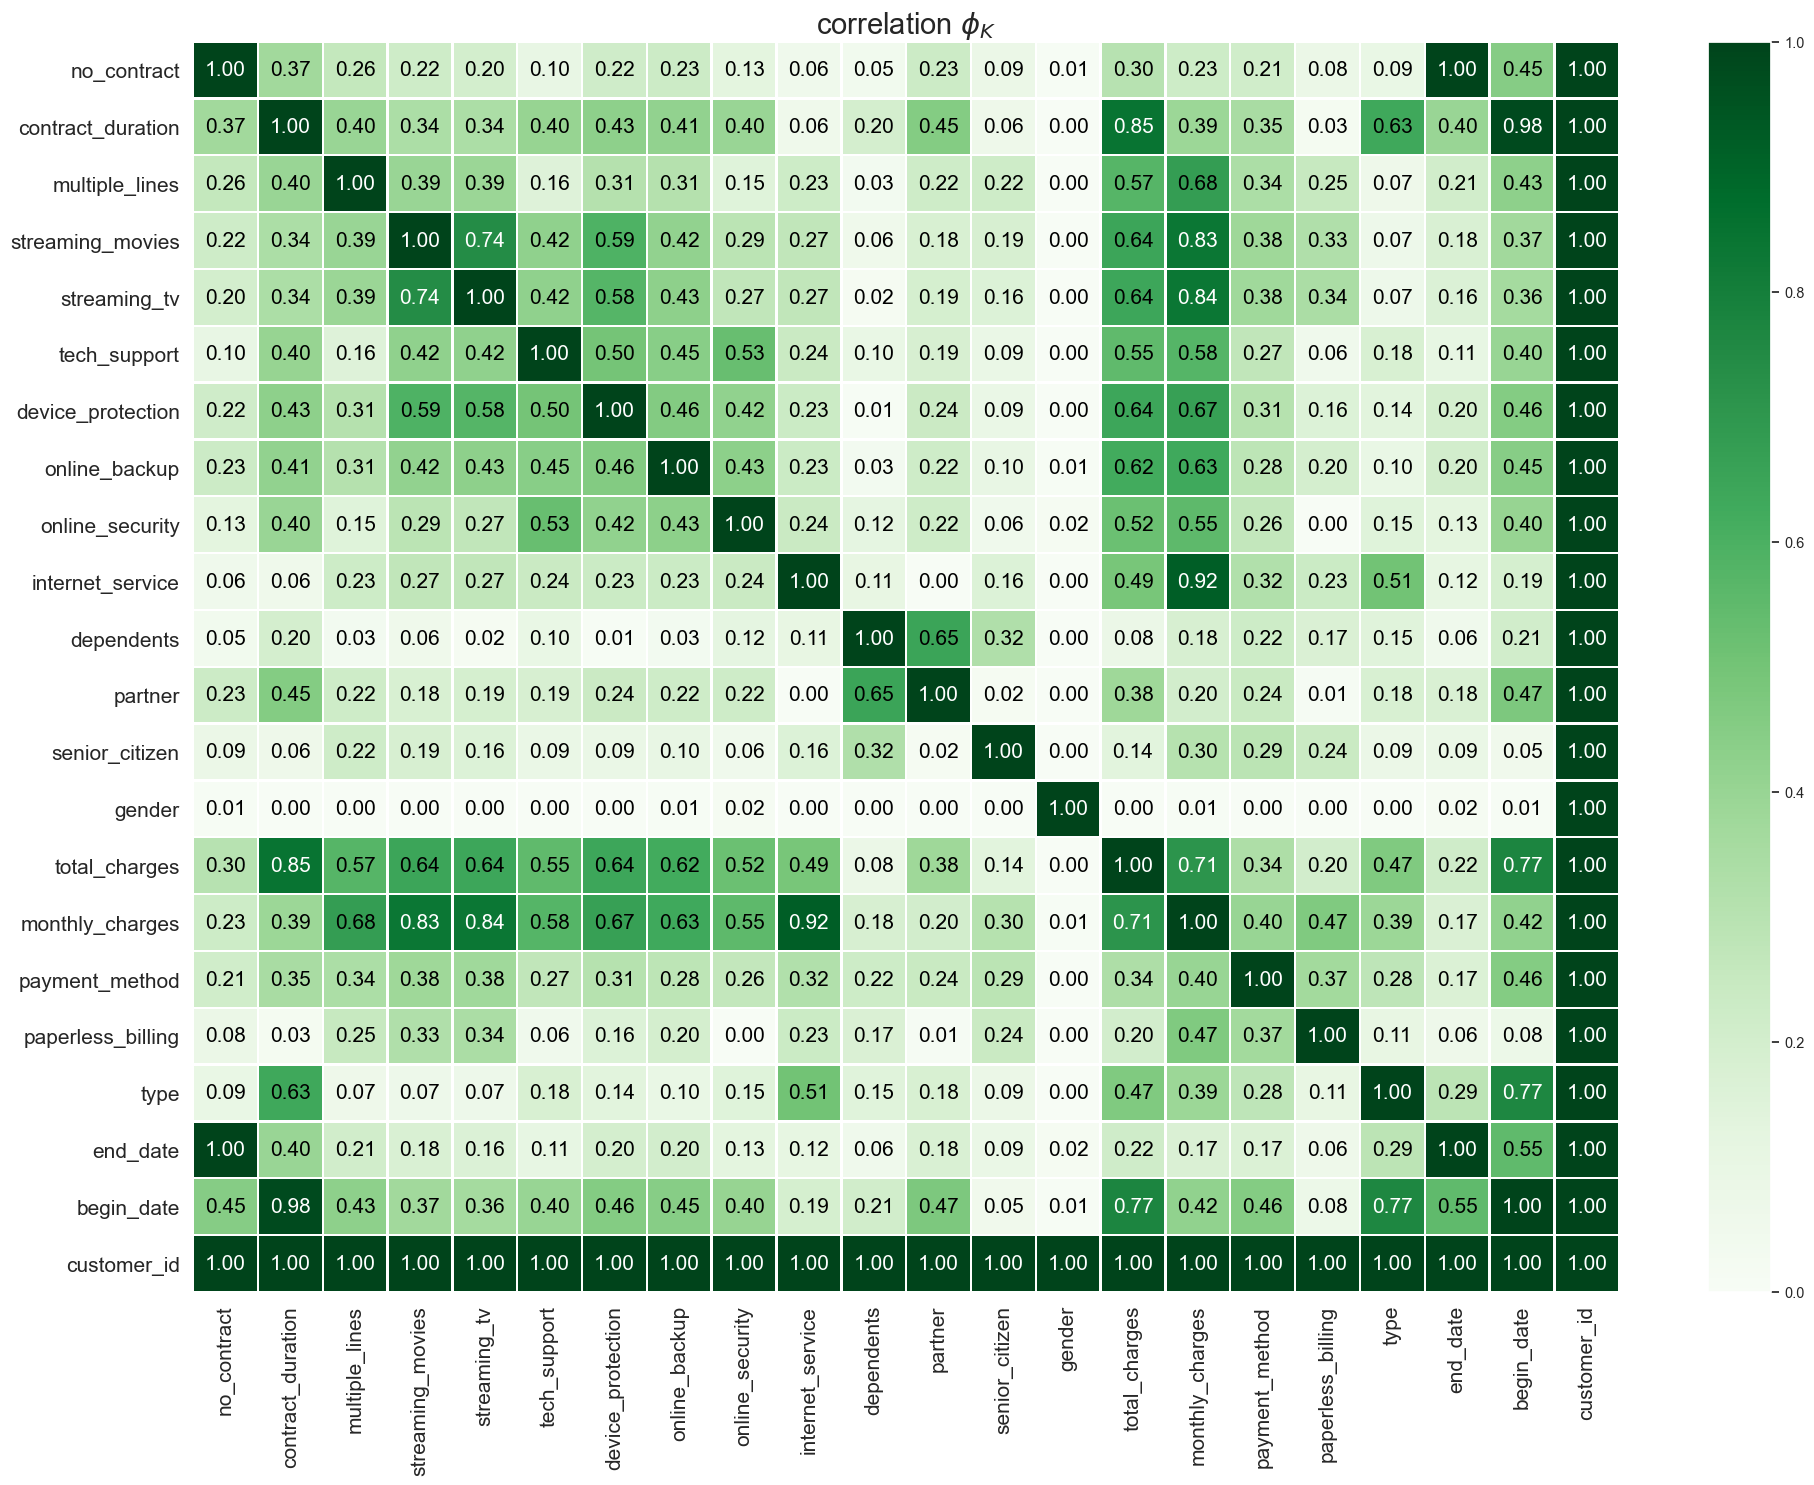

In [42]:
phik_x = full_df.drop('no_contract', axis=1)
phik_y = full_df['no_contract']
interval_cols = full_df.select_dtypes(include=['number'])\
.columns

# считаем корреляции на тренировочной выборке
phik_overview = phik_matrix(
    phik_x.join(phik_y), 
    interval_cols=interval_cols) 

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

- `end_date` и `begin_date` следует удалить, т.к. иначе будет утечка данных. 
- Признак `gender` не влияет на таргет (нет корреляции), его можно удалить.

In [43]:
full_df = full_df.drop(['end_date', 
                        'begin_date',  
                        'gender'], axis=1)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   type               7043 non-null   object 
 2   paperless_billing  7043 non-null   object 
 3   payment_method     7043 non-null   object 
 4   monthly_charges    7043 non-null   float64
 5   total_charges      7043 non-null   float64
 6   no_contract        7043 non-null   int32  
 7   senior_citizen     7043 non-null   int64  
 8   partner            7043 non-null   object 
 9   dependents         7043 non-null   object 
 10  internet_service   7043 non-null   object 
 11  online_security    7043 non-null   object 
 12  online_backup      7043 non-null   object 
 13  device_protection  7043 non-null   object 
 14  tech_support       7043 non-null   object 
 15  streaming_tv       7043 non-null   object 
 16  streaming_movies   7043 

<a id='resan'></a>
### Общий вывод по исследовательскому анализу данных

**Анализ по численным признакам показал следующее:** данные чистые, аномалий и выбросов нет. Пользователей с продолжающимся контрактом значительно больше.

- Медианное и среднее значения **ежемесячных расходов больше у пользователей, разорвавших контракт** (`84.20` против `69.20` по медиане, `75.55` против `62.76` по среднему). 
    - Минимальное и максимальное значения у ушедших абонентов больше, хоть и не значительно (разница в десятых-сотых).
    - Самый высокий пик - на минимальных значениях. Но уушедших клиентов в можно наблюдать второй пик у `100` (у остающихся в районе `70-80`), то есть разрывают контракты чаще либо на минимальной стоимости, либо при больших ежемесячных расходах. 
    - На графике видны множественные пики, что, скорее всего, связано с количеством подключенных услуг.


- Медиана и среднее **общих расходов абонентов, разорвавших контракт**, больше чем у лояльных клиентов (`2139.03` против `1192.80` по медиане, `2371.38` против `2067.94` по среднему).
    - Минимальное значение также больше у ушедших (`77.84` против `19.05`), при этом максимальное значение выше у остающихся (`7649.76` против `9221.38`).
    - Значения убывают, то есть бОльшая часть клиентов не пользуется большинтсвом предоставляемых услуг.

- По медиане и среднему значениям разорвавшие контракт **сотрудничали дольше** (`915` против `702` по медиане, `924.86` против `893.68` по среднему).
    - Максимальное значение у остающихся - `2314` против `2129`.
    - На графике видно два пика среди остающихся - у новых абонентов и у лояльных долгих клиентов.
    - У разовравших контракт пик примерно соответствует медиане/среднему - `900-1000` дней.
    
**Анализ по категориальным признакам показал следующее:**
- Самый популярный **способ оплаты - ежемесячный**. 
    - Но среди ушедших клиентов разница в долях по типам оплаты не особо большая.
- **По типам платежа значительно лидирует электронный чек.**
- **У большинства ушедших абонентов есть партнер**, а у большинства оставшихся нет.
- У большинства абонентов **нет детей**.
- Самый частый **способ подключения** среди клиентов - **оптоволоконный кабель**.
- Абоненты редко пользуются услугой блокировки опасных сайтов.
- **Среди разорвавших контракт доля клиентов, купивших услугу облачного хранилища файлов для резервного копирования данных**, немного превышает долю ушедших клиентов без данной услуги. Среди лояльных клиентов эта услуга встречается не менее часто.
- Лояльные клиенты чаще не пользуются антивирусов, но **среди ушедших доли пользующихся и нет практически равны.**
- Улуга выделенной линии технической поддержки не пользуется популярностью среди клиентов.
- Стриминговое телевидение не очень интересует лояльных клиентов. **Среди разорвавших контракт абонентов доля имевших эту услугу слегка больше, чем не имевших.**
- **Каталог фильмов** лояльных абонентов не особо интересует, а вот **среди разорвавших контракт доля имевших данную услугу выше, чем не имевших.**
- **Подключение телефона к нескольким линиям одновременно** обычно не интересует остающихся клиентов, но **среди ушедших доля имевших услугу больше, чем не имевших.**

То есть клиенты, разорвавшие контракт, часто аользовались несколькими услугами.

**Вывод по анализу коррелиции:**
- `end_date` и `begin_date` удалены, т.к. иначе будет утечка данных. 
- Признак `gender` не влияет на таргет (нет корреляции), поэтому был удален.

<a id='mod'></a>
## Обучение моделей машинного обучения

<a id='bef'></a>
### Предобработка данных

Переведем категориальные данные в тип `category`.

In [44]:
cat_col = full_df.select_dtypes(include=['object'])\
.columns
for col in cat_col:
    full_df[col] = full_df[col].astype('category')
    
full_df['senior_citizen'] = full_df['senior_citizen']\
.astype('category')
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        7043 non-null   category
 1   type               7043 non-null   category
 2   paperless_billing  7043 non-null   category
 3   payment_method     7043 non-null   category
 4   monthly_charges    7043 non-null   float64 
 5   total_charges      7043 non-null   float64 
 6   no_contract        7043 non-null   int32   
 7   senior_citizen     7043 non-null   category
 8   partner            7043 non-null   category
 9   dependents         7043 non-null   category
 10  internet_service   7043 non-null   category
 11  online_security    7043 non-null   category
 12  online_backup      7043 non-null   category
 13  device_protection  7043 non-null   category
 14  tech_support       7043 non-null   category
 15  streaming_tv       7043 non-null   category
 16  stream

Разделим данные на тренировочную и тестовую выборки.

In [45]:
# подготовим выборки для обучения моделей
X = full_df.drop(['customer_id', 'no_contract'], axis=1)
y = full_df['no_contract']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
    )

cat_col = X_train.select_dtypes(include=['category'])\
.columns.to_list()
num_col = X_train.select_dtypes(exclude=['category'])\
.columns.to_list()
cat_col, num_col

(['type',
  'paperless_billing',
  'payment_method',
  'senior_citizen',
  'partner',
  'dependents',
  'internet_service',
  'online_security',
  'online_backup',
  'device_protection',
  'tech_support',
  'streaming_tv',
  'streaming_movies',
  'multiple_lines'],
 ['monthly_charges', 'total_charges', 'contract_duration'])

In [46]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
   [('simpleImputer_ohe', 
     SimpleImputer(missing_values=np.nan, 
                   strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', 
                          handle_unknown='ignore', 
                          sparse_output=False))
   ]
   )

In [47]:
data_preprocessor = ColumnTransformer(
    [('num', MinMaxScaler(), num_col),
     ('category', ohe_pipe, cat_col)
    ],
    remainder='passthrough'
)

<a id='const'></a>
### Константная модель

Посмотрим на метрику модели, предсказывающей константу.

In [48]:
dc_check = DummyClassifier(strategy='constant', constant=0) 
dc_check.fit(X_train, y_train) 

dc_pred = dc_check.predict(X_test) 
dc_rocauc = roc_auc_score(
    y_test,
    dc_pred)
print ('ROC-AUC:', dc_rocauc)

ROC-AUC: 0.5


<a id='log'></a>
### Логистическая регрессия

In [49]:
pipe_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('lr_model', LogisticRegression(
        class_weight='balanced', 
        random_state=RANDOM_STATE,
        n_jobs=-1))
])

In [50]:
params_lr = [
   # словарь для модели LogisticRegression()
   {
       'lr_model': [LogisticRegression(
           random_state=RANDOM_STATE,
           solver='liblinear',
           penalty='l1'
       )],
       'lr_model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
       'lr_model__solver' :['saga', 'lbfgs', 'liblinear'],
       'preprocessor__num': [StandardScaler(), 
                             MinMaxScaler(), 
                             'passthrough'] 
   }
]

In [51]:
rs_lr = RandomizedSearchCV(
    pipe_lr,
    params_lr,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
)

rs_lr.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rs_lr.best_estimator_)
print ('ROC-AUC на кросс-валидации:', rs_lr.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'contract_duration']),
                                                 ('category',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                         

<a id='tree'></a>
### Дерево решений

In [52]:
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('tree_model', DecisionTreeClassifier(
        random_state=RANDOM_STATE))
])

In [53]:
param_tree = [
   # словарь для модели DecisionTreeClassifier()
   {
       'tree_model__max_depth': range(2, 250),
       'tree_model__max_features': range(50, 200),
       'preprocessor__num': [StandardScaler(), 
                             MinMaxScaler(), 
                             'passthrough'] 
   }
]

In [54]:
rs_tree = RandomizedSearchCV(
    pipe_tree,
    param_tree,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
)

rs_tree.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rs_tree.best_estimator_)
print ('ROC-AUC на кросс-валидации:', rs_tree.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'contract_duration']),
                                                 ('category',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                         

<a id='forest'></a>
### Случайный лес

In [55]:
pipe_forest = Pipeline([
    ('preprocessor', data_preprocessor),
    ('forest', RandomForestClassifier(
        random_state=RANDOM_STATE, 
        n_jobs=-1))
])

In [56]:
param_forest = [
   # словарь для модели RandomForestClassifier()
   {
         'forest__criterion' : ['gini', 'entropy'],
         'forest__n_estimators': [250],
         'forest__max_depth': [5, 7, 9],
         'forest__max_features': [3, 5, 7],
         'forest__min_samples_split': [2, 4, 6],
         'forest__min_samples_leaf': [2, 4, 6],
   }
]

In [57]:
rs_forest = RandomizedSearchCV(
    pipe_forest,
    param_forest,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
)

rs_forest.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rs_forest.best_estimator_)
print ('ROC-AUC на кросс-валидации:', rs_forest.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', MinMaxScaler(),
                                                  ['monthly_charges',
                                                   'total_charges',
                                                   'contract_duration']),
                                                 ('category',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                        

<a id='lgbm'></a>
### Модель LightGBM

In [58]:
model_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE,
    verbose=-1)

param_grid_lgbm = {
    'num_leaves': [50, 100, 200],
    'max_depth': [10, 50, 100]
}

In [59]:
rs_lgbm = RandomizedSearchCV(
    model_lgbm,
    param_grid_lgbm,
    cv = 5,
    scoring = 'roc_auc',
    random_state=RANDOM_STATE,
    n_jobs = -1
)

rs_lgbm.fit(X_train, y_train)
print('Лучшая модель и её параметры:\n\n', rs_lgbm.best_estimator_)
print ('ROC-AUC на кросс-валидации:', rs_lgbm.best_score_)

Лучшая модель и её параметры:

 LGBMClassifier(max_depth=50, num_leaves=50, random_state=50824, verbose=-1)
ROC-AUC на кросс-валидации: 0.8652819960244329


<a id='catboost'></a>
### Модель Catboost

In [60]:
model_cat = CatBoostClassifier(
    random_state=RANDOM_STATE,
    thread_count=1)

In [61]:
params_catboost = {
    'depth':  np.arange(2, 11, 2),
    'learning_rate': [0.1, 0.3],
    'iterations': np.arange(100, 2101, 500),
    'l2_leaf_reg': [0.01, 0.1, 1, 3, 5, 7, 10]
}

In [62]:
rs_cat = RandomizedSearchCV(
    model_cat,
    params_catboost,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    random_state=RANDOM_STATE,
)

rs_cat.fit(X_train, y_train, 
           cat_features=cat_col, 
           verbose=0)
print('Лучшая модель и её параметры:\n\n', rs_cat.best_estimator_)
print(rs_cat.best_params_)
print ('ROC-AUC на кросс-валидации:', rs_cat.best_score_)

Лучшая модель и её параметры:

{'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 600, 'depth': 2}
ROC-AUC на кросс-валидации: 0.9280737916811296


<a id='best'></a>
## Выбор лучшей модели

Сравним метрику **ROC-AUC** на кросс-валидации всех моделей.

In [63]:
models_df = pd.DataFrame(
    {'model':['LinearRegression', 
              'DecisionTree',
              'RandomForest',
              'LightGBM', 
              'Catboost'],
     'ROC-AUC': [abs(rs_lr.best_score_), 
              abs(rs_tree.best_score_),
              abs(rs_forest.best_score_),
              abs(rs_lgbm.best_score_),
              abs(rs_cat.best_score_),
             ],
    }
)
models_df

,model,ROC-AUC
0,LinearRegression,0.769937
1,DecisionTree,0.782695
2,RandomForest,0.832025
3,LightGBM,0.865282
4,Catboost,0.928074


Лучшей моделью является `Catboost` с метрикой **ROC-AUC**, равной `0.93`.

Проверим качество лучшей модели на тестовой выборке.

In [64]:
roc_auc_score(y_test, rs_cat.best_estimator_\
              .predict_proba(X_test)[:, 1])

0.9295836748888391

Метрика на тестовой выборке равна `0.93`, что соответствует поставленному критерию (метрика **ROC-AUC** >= 0.85).

Рассмотрим важность признаков модели.

In [65]:
feature_imp = pd.DataFrame(
    rs_cat.best_estimator_.feature_importances_, 
    index = X_test.columns, columns=['percentage'])
feature_imp = feature_imp.sort_values(by='percentage',
                                      ascending=False)
feature_imp

,percentage
contract_duration,69.803734
total_charges,8.149032
monthly_charges,6.767143
type,5.655712
partner,2.144200
payment_method,2.136404
multiple_lines,1.423138
dependents,0.592176
device_protection,0.581083
online_backup,0.579622


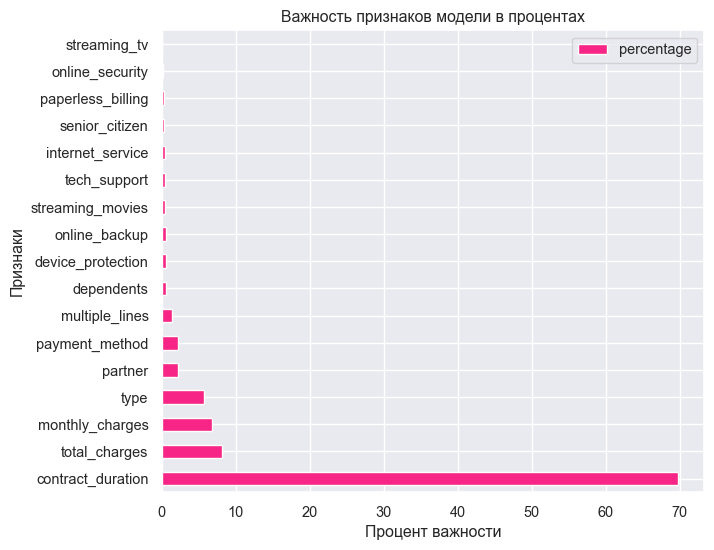

In [66]:
feature_imp.plot(
    kind='barh', 
    title='Важность признаков модели в процентах')
plt.xlabel('Процент важности')
plt.ylabel('Признаки')
plt.show();

Самый важный признак - `contract_duration` (69.80%), далее идут: 
- `monthly_charges` (6.77%)
- `type` (5.66%)
- `partne` (2.14%)
- `payment_method` (2.14%)
- `multiple_line` (1.42%)

Наименее значимый признак `streaming_tv` (0.03%)


Численные признаки оказались более значимыми.


Построим матрицу ошибок.

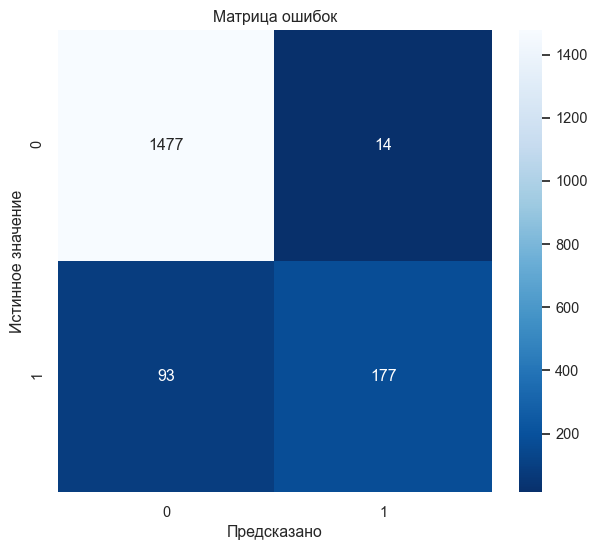

In [67]:
y_preds = rs_cat.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказано');

Модель 14 раз **ошибочно** предсказывает, что абонент разорвет контракт, и 93 раза, что абонент НЕ разорвет контракт. 

В поставленной бизнесом задаче критичнее ошибка второго рода, значит, нельзя допустить ошибочное предсказание, что абонент лоялен и не собирается разрывать контракт - ведь тогда можно упустить клиента. Данная модель хорошо справляется с поставленной задачей. 

<a id='fin'></a>
## Отчет

**Цели проекта выполнены:** 
- Загружены данные, таблицы объединены в единый датафрейм.
- Проведено аналитическое исследование данных.
- Подготовлены выборки для обучения моделей.
- Обучены разные модели и подобраны гиперпараметры.
- Проанализировано качество моделей и выбрана лучшая, предсказывающая готовых разорвать контракт абонентов, проверено её качество на тестовой выборке, построена матрица ошибок.

**Исходные данные:**
Данные состоят из нескольких файлов, полученных из разных источников:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Информация о договорах актуальна на **1 февраля 2020 года**.

**В ходе выполнения работы проделаны следующие шаги:**
- *Загружены и проверены на соответствие данные в датафреймах*.

----------------------------------------
- *Выполнена обработка данных*.
    - Названия столбцов приведены к змеиному регистру; 
    - Выделен целевой признак: датафрейме `contract` с использованием признака `end_date` создан столбец `no_contract` , где значение `No` - не разорванный контракт:
        - 1 - контракт разорван;
        - 0 - контракт НЕ разорван.
    - Вместо значения `No` в столбце `end_date` записана последняя актуальная дата - `2020-02-01`;
    - Пропуски данных (`' '`) в столбце `total_charges` заменены на расходы за месяц;
        - т.к. все контракты с пропусками - новые, видимо, оплата еще не проводилась, либо данные пока не были занесены в базу данных;
    - изменены типы данных тип данных:
        - в `end_date` на `datetime`;
        - в `total_charges` на `float`.
    - Все таблицы упешно объединены в один датафрейм (`full_df`) по `customer_id`.
        - появившиеся пропуски заполнены значением `No` (т.к. пропуски означают отсутствие услуги).

----------------------------------------
- *Проведен исследовательский анализ данных*. 

Данные оказались чистыми, без аномалий и выбросов. Но в данных присутствует дисбаланс классов: **пользователей с продолжающимся контрактом значительно больше, чем разорвавших контракт.**

- Анализ численных признаков показал следующее: 
    - Медианное и среднее значения **ежемесячных расходов больше у пользователей, разорвавших контракт** (`84.20` против `69.20` по медиане, `75.55` против `62.76` по среднему). 
        - Минимальное и максимальное значения у ушедших абонентов больше, хоть и не значительно (разница в десятых-сотых).
        - Самый высокий пик - на минимальных значениях. Но уушедших клиентов в можно наблюдать второй пик у `100` (у остающихся в районе `70-80`), то есть разрывают контракты чаще либо на минимальной стоимости, либо при больших ежемесячных расходах. 
        - На графике видны множественные пики, что, скорее всего, связано с количеством подключенных услуг.

    - Медиана и среднее **общих расходов абонентов, разорвавших контракт**, больше чем у лояльных клиентов (`2139.03` против `1192.80` по медиане, `2371.38` против `2067.94` по среднему).
        - Минимальное значение также больше у ушедших (`77.84` против `19.05`), при этом максимальное значение выше у остающихся (`7649.76` против `9221.38`).
        - Значения убывают, то есть бОльшая часть клиентов не пользуется большинтсвом предоставляемых услуг.

    - По медиане и среднему значениям разорвавшие контракт **сотрудничали дольше** (`915` против `702` по медиане, `924.86` против `893.68` по среднему).
        - Максимальное значение у остающихся - `2314` против `2129`.
        - На графике видно два пика среди остающихся - у новых абонентов и у лояльных долгих клиентов.
        - У разовравших контракт пик примерно соответствует медиане/среднему - `900-1000` дней.


- Анализ категориальных признаков показал следующее:
    - Самый популярный **способ оплаты - ежемесячный**. 
        - Но среди ушедших клиентов разница в долях по типам оплаты не особо большая.
    - **По типам платежа значительно лидирует электронный чек.**
    - **У большинства ушедших абонентов есть партнер**, а у большинства оставшихся нет.
    - У большинства абонентов **нет детей**.
       Самый частый **способ подключения** среди клиентов - **оптоволоконный кабель**.
    - Абоненты редко пользуются услугой блокировки опасных сайтов.
    - **Среди разорвавших контракт доля клиентов, купивших услугу облачного хранилища файлов для резервного копирования данных**, немного превышает долю ушедших клиентов без данной услуги. Среди лояльных клиентов эта услуга встречается не менее часто.
    - Лояльные клиенты чаще не пользуются антивирусов, но **среди ушедших доли пользующихся и нет практически равны.**
    - Улуга выделенной линии технической поддержки не пользуется популярностью среди клиентов.
    - Стриминговое телевидение не очень интересует лояльных клиентов. **Среди разорвавших контракт абонентов доля имевших эту услугу слегка больше, чем не имевших.**
    - **Каталог фильмов** лояльных абонентов не особо интересует, а вот **среди разорвавших контракт доля имевших данную услугу выше, чем не имевших.**
    - **Подключение телефона к нескольким линиям одновременно** обычно не интересует остающихся клиентов, но **среди ушедших доля имевших услугу больше, чем не имевших.**
    - *То есть клиенты, разорвавшие контракт, часто пользуются несколькими услугами.*


- В результате анализа корреляции признаки `end_date` и `begin_date` удалены, т.к. они могут стать причиной утечки данных при обучении моделей. Также удален признак `gender` из-за отсутствия корреляции (т.е. он не влияет на целевой признак).
--------------------------------------------------------------------------
- *Выполнена предобработка данных для последующего обучения моделей*.
    - Данные приведены к типу `category`, необходимому для некоторых моделей.
    - Данные разделены на тренировочную и тестовые выборки.
    - Создана константная модель, чтобы проверить отсутствие утечки данных.
    - Созданы пайпланы с кодированием и масштабированием данных для разных моделей.
--------------------------------------------------------------------------    
- *Обучены пять моделей и к каждой подобраны гиперпараметры*.
    - Логистическая регрессия.
    - Дерево решений.
    - Случайный лес.
    - Модель LightGBM.
    - Модель Catboost.
--------------------------------------------------------------------------   
- *Найдена лучшая модель и ее гиперпараметры, для проверки метрики использована тестовая выборка и построена матрица ошибок*.

#### Описание лучшей модели
Лучшая модель - **модель CatBoost** со следующими параметрами:
`{'learning_rate': 0.3, 'l2_leaf_reg': 3, 'iterations': 600, 'depth': 2}`

- Метрика **ROC-AUC** на кросс-валидации состявляет: `0.93`.
- Метрика **ROC-AUC** на тестовой выборке состявляет: `0.93`.

*Метрика соответствует поставленному заказчиком критерию: **ROC-AUC**>=0.85.*

При обучении этой модели машинного обучения данные не кодировали и не масштабировали, также не учитывался дисбаланс классов, т.к. CatBoost хорошо работает с "сырыми" данными.

Использованные признаки и доля их важности:

In [68]:
feature_imp

,percentage
contract_duration,69.803734
total_charges,8.149032
monthly_charges,6.767143
type,5.655712
partner,2.144200
payment_method,2.136404
multiple_lines,1.423138
dependents,0.592176
device_protection,0.581083
online_backup,0.579622


Полученная модель выполняет необходимые условия и решает поставленные бизнесом задачи, а именно предсказывает абонентов, желающих расторгнуть контракт.

- Предсказания модели можно улучшить, для этого можно собрать дополнительную информацию или создать больше признаков, также можно уменьшить дисбаланс классов или использовать другие модели.

[Наверх][1]

[1]:#task